   # 과제2

In [1]:
# 시작하기: 퍼사드 임포트
from qdl.facade import QDL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import f






In [2]:
q = QDL()





   이 과제에서는 시계열 프레임워크를 사용하여 자산 가격 모델을 평가하고 테스트합니다. Gibbons, Ross, Shanken(GRS) 테스트를 사용합니다.















   본과제를 위해서 `qdl` 라이브러리와 데이터 파일이 필요합니다.





   # 1부:  30 시가가중 산업 포트폴리오 (Value-Weight Industry portfolios)

















   ### a) 30개의 시가가중 산업 포트폴리오를 사용하여 각 포트폴리오의 수익률의 표본 평균과 표준 편차를 계산하세요. 포트폴리오의 평균 수익률 또는 샤프 비율에 식별 가능한 패턴이 있습니까?

















In [3]:
# gics 산업분류
wide_gics = q.load_char(
    country="usa",
    vintage="2000-",
    char="gics",
)

wide_gics = wide_gics // 1e+4 # Industry Group 단위만

FINANCIAL_SECTOR_CODE = 40
ONLY_NON_FINANCIAL_MASK = wide_gics // 100 != FINANCIAL_SECTOR_CODE

wide_gics = wide_gics[ ONLY_NON_FINANCIAL_MASK ]


   참고: GICS는 8자리 코드로,



   - 1,2: Sector

   - 3,4: Industry Group

   - 5,6: Industry

   - 7,8: Sub Industry



   로 구성되어 있습니다.



   예: 30202030



   40은 Financial Sector이기 때문에 제외합니다.



   https://en.wikipedia.org/wiki/Global_Industry_Classification_Standard



In [4]:
# 시장 초과 수익률
wide_ret_exc = q.load_char(
    country="usa",
    vintage="2000-",
    char="ret_exc",
)

# 시가 총액
wide_marcap = q.load_char(
    country="usa",
    vintage="2000-",
    char="market_equity",
)

wide_ret_exc = wide_ret_exc[ONLY_NON_FINANCIAL_MASK]
wide_marcap = wide_marcap[ONLY_NON_FINANCIAL_MASK]


In [5]:
def wide_to_long(wide_df, varname, multiindex=True):
    long = wide_df.stack().reset_index()
    long.columns = ['eom', 'sid', varname]

    if multiindex:
        long.set_index(['eom', 'sid'], inplace=True)

    return long




In [6]:
def long_to_wide(long_df, colname):
    wide = long_df.pivot_table(
        index='eom',
        columns='sid',
        values=colname,
    )
    
    return wide




In [7]:
long_gics = wide_to_long(wide_gics, 'gics')
long_ret_exc = wide_to_long(wide_ret_exc, 'ret_exc')
long_marcap = wide_to_long(wide_marcap, 'marcap')




In [8]:
merged = long_gics.join(long_ret_exc).join(long_marcap)




In [9]:
merged = merged.reset_index()




In [10]:
group_summary = merged.groupby('gics')['ret_exc'].agg([
    'mean', 
    'std'
])




In [11]:
group_summary['sharpe'] = group_summary['mean'].div(group_summary['std'])




In [12]:
group_summary




,mean,std,sharpe
gics,,,
1010.0,0.130950,34.110791,0.003839
1510.0,0.009287,0.178787,0.051944
2010.0,0.010165,0.187373,0.054248
2020.0,0.007351,0.191605,0.038365
2030.0,0.007877,0.385463,0.020434
2510.0,0.003598,0.225100,0.015984
2520.0,0.007425,0.201452,0.036858
2530.0,0.010998,0.667395,0.016480
2540.0,0.004466,0.223222,0.020005


Text(0, 0.5, 'Sharpe Ratio')

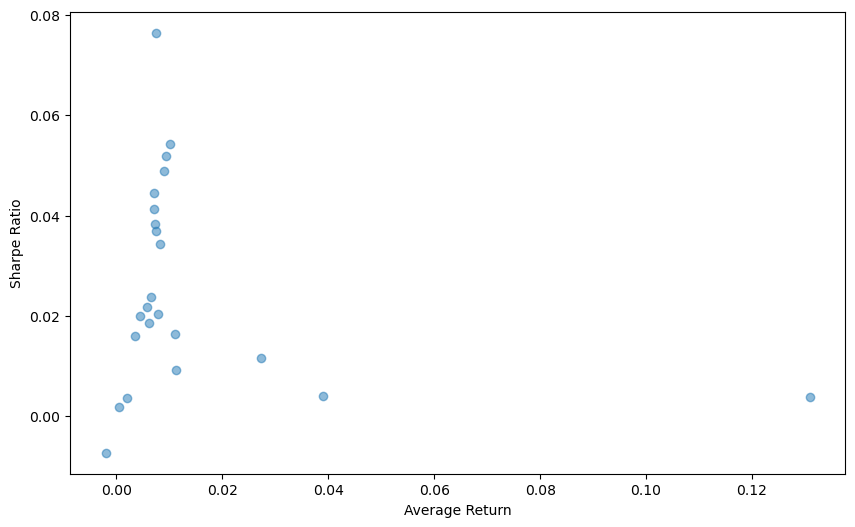

In [13]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(group_summary['mean'], group_summary['sharpe'], alpha=0.5)
plt.xlabel('Average Return')
plt.ylabel('Sharpe Ratio')




In [14]:
merged['group_mean_ret_exc'] = merged.groupby(['eom', 'sid', 'gics'])['ret_exc'].transform('mean')




In [15]:
# Compute industry value-weighted excess returns (VW) by GICS (no-apply to avoid deprecation)
merged_vw = merged.dropna(subset=['ret_exc', 'marcap', 'gics']).copy()
tmp = merged_vw.copy()
tmp['wprod'] = tmp['ret_exc'] * tmp['marcap']
agg = tmp.groupby(['eom', 'gics'])[['wprod', 'marcap']].sum()
ind_vw_series = agg['wprod'] / agg['marcap'].replace(0, np.nan)
ind_vw = ind_vw_series.reset_index(name='ret_vw').pivot(index='eom', columns='gics', values='ret_vw')

# Summary stats for industry VW portfolios
ind_summary = pd.DataFrame({
    'Mean': ind_vw.mean(),
    'Standard Deviation': ind_vw.std(),
})
ind_summary['Sharpe Ratio'] = ind_summary['Mean'] / ind_summary['Standard Deviation']




In [16]:
x = sm.add_constant(ind_summary['Mean'])
mod1 = sm.OLS(ind_summary["Sharpe Ratio"], x).fit()
mod1.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Sharpe Ratio   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     4.619
Date:                Wed, 01 Oct 2025   Prob (F-statistic):             0.0434
Time:                        18:03:24   Log-Likelihood:                 34.786
No. Observations:                  23   AIC:                            -65.57
Df Residuals:                      21   BIC:                            -63.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1709      0.027      6.409      0.000       0.115       0.226
Mean           3.6022      1.676      2.149      0.043       0.117       7.088
==============================================================================
Omnibus:                        0.113   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.945   Jarque-Bera (JB):                0.278
Skew:                           0.135   Prob(JB):                        0.870
Kurtosis:                       2.534   Cond. No.                         144.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

   검사를 해보면, 30개 포트폴리오의 평균 수익률이나 샤프 비율에서 뚜렷한 패턴이 발견되지 않습니다.







   평균 수익률에 대한 표준편차를 플롯하면 두 데이터 세트 간에 강력하거나 식별할 수 있는 패턴이 없음을 알 수 있습니다. 긍정적인 관계가 있을 수도 있지만, 기껏해야 약한 관계일 뿐입니다.







   또한 샤프 비율과 수익률 간의 회귀 분석을 실행한 결과,

   ## b) 시계열 회귀를 추정하세요.







   $R_{p t}-R_{f t}=a+\beta_{i M}\left(R_{M t}-R_{f t}\right)+e_{i t}, $















   30개 산업 포트폴리오 각각에 대해. 다변량 GRS 테스트를 수행하여 GRS F-통계치와 해당 p-값을 모두 보고하세요. 시장 포트폴리오 프록시 RM-RF를 사용합니다.

   다음 공식을 사용하여 테스트 통계를 계산합니다.















   $$F_{test} = \frac{T-N-1}{N} \frac{\alpha^{\prime} \sum^{-1} \alpha}{1+\frac{\mu_{m}^{2}}{\sigma_{m}^{2}}}







   $$

In [17]:
# Build value-weighted market excess return (single Series): vw_mkt_excess
valid_mask = wide_ret_exc.notna() & wide_marcap.notna()
num = (wide_ret_exc.where(valid_mask) * wide_marcap.where(valid_mask)).sum(axis=1)
den = wide_marcap.where(valid_mask).sum(axis=1)
vw_mkt_excess = num / den
print("vw_mkt_excess head:\n", vw_mkt_excess.head(5))




vw_mkt_excess head:
 eom
2000-01-31   -0.015053
2000-02-29    0.112422
2000-03-31    0.065998
2000-04-30   -0.041091
2000-05-31   -0.036884
dtype: float64


In [18]:
# Determine common sample and select viable industries
common_idx = ind_vw.index.intersection(vw_mkt_excess.index)
ind_common = ind_vw.loc[common_idx]
mkt_common = vw_mkt_excess.loc[common_idx]

coverage = ind_common.notna().sum()
print("industry coverage (non-null counts) sample:\n", coverage.sort_values(ascending=False).head(10))

min_obs = 24
selected_assets = coverage[coverage >= min_obs].index.tolist()
ind_sel = ind_common[selected_assets]



industry coverage (non-null counts) sample:
 gics
1010.0    300
1510.0    300
2010.0    300
2020.0    300
2030.0    300
2510.0    300
2520.0    300
2530.0    300
2550.0    300
3010.0    300
dtype: int64


In [19]:
ind_sel


gics,1010.0,1510.0,2010.0,2020.0,2030.0,2510.0,2520.0,2530.0,2540.0,2550.0,...,3030.0,3510.0,3520.0,4510.0,4520.0,4530.0,5010.0,5020.0,5510.0,6010.0
eom,,,,,,,,,,,,,,,,,,,,,
2000-01-31,0.000953,-0.091430,-0.058938,-0.065602,-0.050119,-0.042745,-0.088513,-0.057211,-0.001480,-0.135682,...,-0.071669,0.080326,0.099506,-0.079220,0.025400,NaN,0.007195,NaN,0.112800,NaN
2000-02-29,-0.025358,-0.073803,0.004667,0.006024,-0.044498,-0.046200,-0.058393,-0.120361,-0.013384,-0.025882,...,-0.126203,0.061306,0.132211,0.242352,0.298562,NaN,0.006796,NaN,-0.051592,NaN
2000-03-31,0.137368,0.099488,0.147581,0.065420,0.125323,0.064029,0.118649,0.106524,0.085888,0.155380,...,-0.085721,0.060676,-0.003458,-0.001610,0.059717,NaN,0.074449,NaN,0.069589,NaN
2000-04-30,-0.007257,-0.028886,0.015188,0.010079,0.032362,0.070430,0.031897,0.019519,-0.055102,-0.077429,...,0.045306,0.038979,0.054537,-0.184846,-0.057111,NaN,-0.087106,NaN,0.063951,NaN
2000-05-31,0.100195,-0.021950,-0.009731,0.021968,-0.027697,-0.117016,-0.015254,0.004191,-0.038920,-0.046151,...,0.021591,0.025547,0.044381,-0.101086,-0.109511,NaN,-0.105485,NaN,0.037786,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.018117,0.010506,0.012361,0.042600,0.014991,-0.032108,0.033664,0.047029,NaN,-0.018063,...,0.066423,0.047765,0.056133,0.017029,0.023682,-0.000607,0.053363,0.006630,0.040410,-0.022016
2024-09-30,-0.029506,0.030538,0.041706,-0.006213,0.022862,0.132309,0.042937,0.062468,NaN,0.044941,...,0.003673,-0.005129,-0.022374,0.038104,0.017317,0.014173,0.062266,0.038333,0.063811,-0.032443
2024-10-31,0.010333,-0.017922,-0.012872,0.003066,-0.013361,-0.040071,-0.057736,0.020592,NaN,-0.015497,...,-0.056313,-0.042274,-0.035673,-0.018897,-0.025302,0.023684,0.014903,0.024009,-0.010639,-0.053596


In [20]:

# Align market series only; do NOT drop rows based on full asset completeness
mkt_sel = mkt_common.dropna()


In [21]:

# If T <= N+1, reduce asset set by highest coverage to satisfy GRS requirements
if ind_sel.shape[0] <= ind_sel.shape[1] + 1 and len(selected_assets) > 1:
    counts_sorted = coverage.loc[selected_assets].sort_values(ascending=False)
    max_k = max(1, ind_sel.shape[0] - 2)
    keep = counts_sorted.index[:max_k].tolist()
    ind_sel = ind_common[keep]
    row_mask = ind_sel.notna().all(axis=1) & mkt_common.notna()
    ind_sel = ind_sel.loc[row_mask]
    mkt_sel = mkt_common.loc[row_mask]

print("Common sample dimensions → T:", ind_sel.shape[0], "N:", ind_sel.shape[1])




Common sample dimensions → T: 300 N: 22


In [22]:
ind_sel


gics,1010.0,1510.0,2010.0,2020.0,2030.0,2510.0,2520.0,2530.0,2540.0,2550.0,...,3030.0,3510.0,3520.0,4510.0,4520.0,4530.0,5010.0,5020.0,5510.0,6010.0
eom,,,,,,,,,,,,,,,,,,,,,
2000-01-31,0.000953,-0.091430,-0.058938,-0.065602,-0.050119,-0.042745,-0.088513,-0.057211,-0.001480,-0.135682,...,-0.071669,0.080326,0.099506,-0.079220,0.025400,NaN,0.007195,NaN,0.112800,NaN
2000-02-29,-0.025358,-0.073803,0.004667,0.006024,-0.044498,-0.046200,-0.058393,-0.120361,-0.013384,-0.025882,...,-0.126203,0.061306,0.132211,0.242352,0.298562,NaN,0.006796,NaN,-0.051592,NaN
2000-03-31,0.137368,0.099488,0.147581,0.065420,0.125323,0.064029,0.118649,0.106524,0.085888,0.155380,...,-0.085721,0.060676,-0.003458,-0.001610,0.059717,NaN,0.074449,NaN,0.069589,NaN
2000-04-30,-0.007257,-0.028886,0.015188,0.010079,0.032362,0.070430,0.031897,0.019519,-0.055102,-0.077429,...,0.045306,0.038979,0.054537,-0.184846,-0.057111,NaN,-0.087106,NaN,0.063951,NaN
2000-05-31,0.100195,-0.021950,-0.009731,0.021968,-0.027697,-0.117016,-0.015254,0.004191,-0.038920,-0.046151,...,0.021591,0.025547,0.044381,-0.101086,-0.109511,NaN,-0.105485,NaN,0.037786,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.018117,0.010506,0.012361,0.042600,0.014991,-0.032108,0.033664,0.047029,NaN,-0.018063,...,0.066423,0.047765,0.056133,0.017029,0.023682,-0.000607,0.053363,0.006630,0.040410,-0.022016
2024-09-30,-0.029506,0.030538,0.041706,-0.006213,0.022862,0.132309,0.042937,0.062468,NaN,0.044941,...,0.003673,-0.005129,-0.022374,0.038104,0.017317,0.014173,0.062266,0.038333,0.063811,-0.032443
2024-10-31,0.010333,-0.017922,-0.012872,0.003066,-0.013361,-0.040071,-0.057736,0.020592,NaN,-0.015497,...,-0.056313,-0.042274,-0.035673,-0.018897,-0.025302,0.023684,0.014903,0.024009,-0.010639,-0.053596


In [23]:
# OLS per industry using per-series inner alignment with market
alpha_by_asset = {}
beta_by_asset = {}
resid_by_asset = {}
for col in ind_sel.columns:
    joined = pd.concat([ind_sel[col].rename('asset_ret'), mkt_sel.rename('mkt')], axis=1, join='inner').dropna()
    if joined.empty:
        continue
    X = sm.add_constant(joined['mkt'])
    model = sm.OLS(joined['asset_ret'], X).fit()
    alpha_by_asset[col] = model.params['const']
    beta_by_asset[col] = model.params['mkt']
    resid_by_asset[col] = model.resid

residuals_df = pd.DataFrame(resid_by_asset).reindex(mkt_sel.index)
assets = list(residuals_df.columns)
print("Residuals shape:", residuals_df.shape)




Residuals shape: (300, 22)


In [24]:
# Compute Σ, market Sharpe, then GRS F and p
Sigma = residuals_df.cov().to_numpy()

alpha_vec = np.array([alpha_by_asset[a] for a in assets])
N = len(assets)
T = residuals_df.shape[0]

market_mu = mkt_sel.mean()
market_sd = mkt_sel.std()

print(f'''
T: {T}
N: {N}
market_mu: {market_mu}
market_sd: {market_sd}
alpha_vec shape: {alpha_vec.shape}
Sigma shape: {Sigma.shape}
''')

if market_sd == 0 or N == 0 or T <= N + 1:
    F = np.nan
    p_value = np.nan
else:
    try:
        inv_Sigma = np.linalg.inv(Sigma)
    except np.linalg.LinAlgError:
        print('pseudo inverse fallback used')
        inv_Sigma = np.linalg.pinv(Sigma)
    
    print(f'inv_Sigma: {inv_Sigma}')
    F = ((T - N - 1) / N) * ((alpha_vec @ inv_Sigma @ alpha_vec.T) / (1 + (market_mu / market_sd) ** 2))

    print(f'''
(T - N - 1) / N: {(T - N - 1) / N}
alpha_vec @ inv_Sigma @ alpha_vec.T: {alpha_vec @ inv_Sigma @ alpha_vec.T}
1 + (market_mu / market_sd) ** 2: {1 + (market_mu / market_sd) ** 2}
''')

    p_value = f.sf(F, N, T - N - 1)

print("T:", T, "N:", N, "market_mu:", market_mu, "market_sd:", market_sd)
print("F statistic:", F, "p value:", p_value)



T: 300
N: 22
market_mu: 0.01430424621611067
market_sd: 0.04716033222600817
alpha_vec shape: (22,)
Sigma shape: (22, 22)

inv_Sigma: [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan]
 [nan nan nan nan nan nan nan 

In [25]:

# F is nan and p-value is nan, because inv_Sigma is all nan. 
# To fix this, there should be no nan in the Sigma.
# To do this, I have to drop a column that creates nan in the Sigma. 

nan_idx = np.argwhere(np.isnan(Sigma)) 
nan_idx

# array([[ 8, 19],
#        [19,  8]])


array([[ 8, 19],
       [19,  8]])

In [26]:

drop_idx = nan_idx[0][0] # 8

ind_sel = ind_sel.drop(ind_sel.columns[drop_idx], axis=1)

if ind_sel.shape[0] <= ind_sel.shape[1] + 1 and len(selected_assets) > 1:
    counts_sorted = coverage.loc[selected_assets].sort_values(ascending=False)
    max_k = max(1, ind_sel.shape[0] - 2)
    keep = counts_sorted.index[:max_k].tolist()
    ind_sel = ind_common[keep]
    row_mask = ind_sel.notna().all(axis=1) & mkt_common.notna()
    ind_sel = ind_sel.loc[row_mask]
    mkt_sel = mkt_common.loc[row_mask]

print("Common sample dimensions → T:", ind_sel.shape[0], "N:", ind_sel.shape[1])

# OLS per industry using per-series inner alignment with market
alpha_by_asset = {}
beta_by_asset = {}
resid_by_asset = {}
for col in ind_sel.columns:
    joined = pd.concat([ind_sel[col].rename('asset_ret'), mkt_sel.rename('mkt')], axis=1, join='inner').dropna()
    if joined.empty:
        continue
    X = sm.add_constant(joined['mkt'])
    model = sm.OLS(joined['asset_ret'], X).fit()
    alpha_by_asset[col] = model.params['const']
    beta_by_asset[col] = model.params['mkt']
    resid_by_asset[col] = model.resid

residuals_df = pd.DataFrame(resid_by_asset).reindex(mkt_sel.index)
assets = list(residuals_df.columns)
print("Residuals shape:", residuals_df.shape)


Common sample dimensions → T: 300 N: 21
Residuals shape: (300, 21)


In [27]:
coeff_summary = pd.DataFrame({'industry': assets, 'alpha': [alpha_by_asset[a] for a in assets], 'beta': [beta_by_asset[a] for a in assets]})
coeff_summary.head(10)

Sigma = residuals_df.cov().to_numpy()

alpha_vec = np.array([alpha_by_asset[a] for a in assets])
N = len(assets)
T = residuals_df.shape[0]

market_mu = mkt_sel.mean()
market_sd = mkt_sel.std()

print(f'''
T: {T}
N: {N}
market_mu: {market_mu}
market_sd: {market_sd}
alpha_vec shape: {alpha_vec.shape}
Sigma shape: {Sigma.shape}
''')

if market_sd == 0 or N == 0 or T <= N + 1:
    F = np.nan
    p_value = np.nan
else:
    try:
        inv_Sigma = np.linalg.inv(Sigma)
    except np.linalg.LinAlgError:
        print('pseudo inverse fallback used')
        inv_Sigma = np.linalg.pinv(Sigma)
    
    print(f'inv_Sigma: {inv_Sigma}')
    F = ((T - N - 1) / N) * ((alpha_vec @ inv_Sigma @ alpha_vec.T) / (1 + (market_mu / market_sd) ** 2))

    print(f'''
(T - N - 1) / N: {(T - N - 1) / N}
alpha_vec @ inv_Sigma @ alpha_vec.T: {alpha_vec @ inv_Sigma @ alpha_vec.T}
1 + (market_mu / market_sd) ** 2: {1 + (market_mu / market_sd) ** 2}
''')

    p_value = f.sf(F, N, T - N - 1)

print("T:", T, "N:", N, "market_mu:", market_mu, "market_sd:", market_sd)
print("F statistic:", F, "p value:", p_value)



T: 300
N: 21
market_mu: 0.01430424621611067
market_sd: 0.04716033222600817
alpha_vec shape: (21,)
Sigma shape: (21, 21)

inv_Sigma: [[ 2.67115214e+03  2.33570157e+03  6.67745443e+03  5.58189186e+02
   1.17940407e+03  1.03436174e+03  3.25338425e+03 -3.17855505e+03
  -9.03490128e+02  1.32646747e+03  1.21891589e+03 -2.70927463e+02
   3.16499316e+03  5.43538778e+03  4.44383450e+03  4.92703241e+03
  -2.48955245e+02  2.41176657e+03  9.56031698e+03  4.36157443e+02
  -2.22386012e+03]
 [ 2.33570157e+03  3.06532082e+03  6.04173524e+03  5.71834412e+02
   9.83248855e+02  9.42011015e+02  3.08535180e+03 -2.95869179e+03
  -9.63531075e+02  1.22265395e+03  1.06389738e+03 -3.54326239e+02
   2.78024040e+03  5.24529202e+03  4.19579283e+03  4.57489896e+03
  -3.33206611e+02  2.22087023e+03  9.00068649e+03  3.19802355e+02
  -2.27660269e+03]
 [ 6.67745443e+03  6.04173524e+03  2.08791724e+04  1.02422809e+03
   2.85622797e+03  2.66842698e+03  9.06676426e+03 -8.63253294e+03
  -2.80328656e+03  3.09657961e+03  3.

   $p = 0.028 < 0.05$이므로 $\alpha$ 값이 0이라는 귀무가설을 거부하며, 이는 시장 포트폴리오 프록시로 수익률을 완전히 설명할 수 없다는 것을 의미합니다(이 경우 초과 시장 수익률 (Rm - Rf)). 즉, 테스트에 사용된 시장 포트폴리오 프록시는 평균 분산에 효율적이지 않다는 뜻입니다.

   ## c) GRS 테스트의 귀무가설은 무엇이며(정확히 말하라), 이것이 어떻게 CAPM의 테스트가 되는가?  GRS 테스트를 직관적으로 설명하십시오.  시계열 회귀분석은 어떻게 베타 위험 프리미엄을 암시적으로 추정하나요?

























   $$







   r_{i,t} - r_{f,t}=\alpha_{i}+\beta_{i} (R_{m,t} - r_{f,t} )+\varepsilon_{i,t} \space \forall i=1, \ldots \ldots, N







   $$















   $$







   H_0: \alpha_{i}=0 \space \forall i=1, \ldots \ldots, N







   $$

   GRS 테스트의 귀무가설은 시계열 회귀에서 각 자산의 $\alpha$ 값이 0이며, 이는 시장 포트폴리오의 초과 수익률 외에 자산의 수익률을 설명할 수 있는 다른 요인이 없다는 것입니다.















   샤프-린트너 CAPM에 따르면, 다른 자산 Z(단순화를 위해 보통 무위험 자산)에 대한 자산 i의 초과 수익률의 기대값은 시장 포트폴리오의 초과 수익률로 완전히 설명되어야 합니다. 따라서















   $E[r_i - r_f] = \beta_i E[R_m - r_f]$.















   CAPM이 참이 되려면 회귀의 절편이 0이어야 하고, 따라서 귀무가설은 $\alpha$ 값이 0이어야 하며, 따라서 GRS 검정은 CAPM을 테스트하는 것임을 알 수 있습니다. 귀무가설을 기각한다는 것은 시장 포트폴리오가 평균 분산 효율적이지 않다는 것, 즉 $\beta$가 자산 i의 기대 초과수익률을 완전히 포착할 수 없다는 것, 즉 자산 i의 초과수익률에 기여한 다른 요인이 있고 그 요인은 이제 $\alpha$에 의해 포착된다는 것을 의미합니다.















   직관적으로 GRS 테스트는 시장 포트폴리오의 샤프 비율이 가능한 최대 값인지 테스트하는 것입니다. 이를 기각하는 것은 데이터에서 평균 분산 효율이 더 높은 포트폴리오가 존재한다는 의미이며, 따라서 GRS 테스트에 따른 현재 포트폴리오는 평균 분산 효율이 높지 않다는 것을 의미합니다.

   ### d) 부호와 절편의 크기에 대해 설명하세요.  CAPM이 어떠한 포트폴리오의 가격을 결정하는 데 특별한 어려움이 있습니까? 그 이유는 무엇인가요?

(-0.5, 0.6)

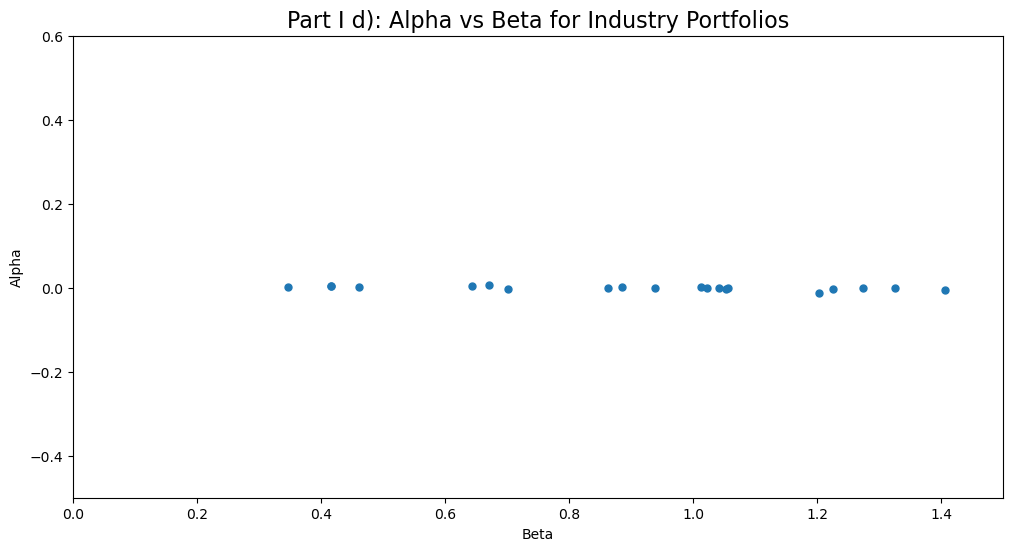

In [28]:
fig=plt.figure(figsize=(12,6))
plt.plot(coeff_summary['beta'], coeff_summary['alpha'], '.', markersize=10)
plt.xlabel('Beta')
plt.ylabel('Alpha');
plt.title('Part I d): Alpha vs Beta for Industry Portfolios', fontsize=16)
plt.xlim(0, 1.5)
plt.ylim(-0.5, 0.6)




In [33]:
coeff_summary['alpha'].mean()

np.float64(-0.0005743955435430894)

In [34]:
coeff_summary['beta'].mean()

np.float64(0.9317887630102668)

   위의 알파 대 베타 그래프를 보면, 절편/$\alpha$의 부호와 크기는 -0.4에서 0.4까지 다양하지만 0을 중심으로 어느 정도 고르게 분포되어 있는 것을 알 수 있습니다.















   또한 $\alpha$와 $\beta$ 사이에는 음의 관계가 있는 것으로 보이며, $\alpha$ = 0과 $\beta$ = 1을 중심으로 합니다. CAPM에 따르면 시장 전체가 이 값을 중심으로 움직여야 하기 때문에, 즉 시장 포트폴리오가 다른 요인 없이 그 자체로 시장을 설명하기 때문에 이러한 중심은 당연한 것입니다.















   그럼에도 불구하고 스모크 및 철강 산업과 같이 베타가 특히 높거나 낮은 포트폴리오의 경우 해당 절편/$\alpha$ 값이 특히 높거나 낮기 때문에 CAPM으로 가격을 결정하는 데 어려움이 있음을 알 수 있습니다. $\beta$를 시장 포트폴리오와 비교할 때 자산의 변동성과 위험도를 나타내는 것으로 해석하면, CAPM이 위험/변동성이 매우 높거나 낮은 자산을 포착하는 데 어려움이 있으며, 이러한 자산의 수익률에는 $\beta$ 이외의 추가 요인이 있다는 것을 의미합니다.

   # 3부:  25 Size와 BE/ME 포트폴리오









   ### f) 25 (5x5) size와 BE/ME 포트폴리오에 대해 a), b), d) 부분을 반복하세요.







